# Dask Array

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Dask"
* https://docs.dask.org/en/latest/array.html

In [2]:
pip install dask

     ---------------------------------------- 1.1/1.1 MB 6.5 MB/s eta 0:00:00
     ---------------------------------------- 155.4/155.4 kB ? eta 0:00:00
     ---------------------------------------- 55.8/55.8 kB 2.8 MB/s eta 0:00:00
     -------------------------------------- 139.5/139.5 kB 8.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install h5py

     ---------------------------------------- 2.6/2.6 MB 9.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import dask.array as da
import h5py
import numpy as np
import dask
import pandas as pd

In [3]:
!pip install graphviz 

     ---------------------------------------- 47.0/47.0 kB 2.5 MB/s eta 0:00:00


## Задачи для совместного разбора

1. Создайте массив размерностью 1000 на 300000, заполненный числами из стандартного нормального распределения. Исследуйте основные характеристики полученного массива. Визуализируйте граф вычисления задачи.

In [2]:
import numpy as np
import h5py

with h5py.File("demo.h5", "w") as hdf:
    hdf.create_dataset('arr', data = np.random.normal(0, 1, size = (1000, 300_000)))

In [4]:
hdf = h5py.File("demo.h5", "r")
dset = hdf['arr']
dset

<HDF5 dataset "arr": shape (1000, 300000), type "<f8">

In [5]:
arr = da.from_array(dset)
arr

dask.array<array, shape=(1000, 300000), dtype=float64, chunksize=(1000, 16777), chunktype=numpy.ndarray>

In [10]:
%%time 

#Метод отложенных вычислений основа dask
arr.mean().compute()  # До вызова compute  все вычисления делаются исключительно как подготовительные, без реальных вычислений

CPU times: total: 1.92 s
Wall time: 1.24 s


-1.6235052316324293e-05

In [16]:
%%time

arr1 = arr * 2
s = arr1.sum()
print(s.compute())
m = arr1.mean()
print(m.compute())

-9741.031389794576
-3.247010463264859e-05
CPU times: total: 9.27 s
Wall time: 3.79 s


In [14]:
%%time

arr1 = arr * 2
s = arr1.sum()
m = arr1.mean()

print(dask.compute(s, m))

(-9741.031389794576, -3.247010463264859e-05)
CPU times: total: 5.81 s
Wall time: 2.05 s


2. Посчитайте сумму квадратов элементов массива, созданного в задаче 1. Создайте массив `np.array` такого же размера и сравните скорость решения задачи с использование `da.array` и `np.array`

In [21]:
%%time

arr_np = np.random.normal(0, 1, size = (1000, 300000))
(arr_np ** 2).sum()

CPU times: total: 8.47 s
Wall time: 8.46 s


300064837.7956844

In [23]:
%%timeit

arr_da = da.random.normal(0, 1, size = (1000, 300000))
(arr_da ** 2).sum().compute()

2.49 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Лабораторная работа 11

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений (расчет средних значений, расчет косинусной близости и т.д.) проводятся над `dask.array` и средствами пакета `dask`, если в задании не сказано обратного. Переход от `dask.array` к `numpy.array` или `pd.DataFrame` возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.array` (то есть то, что было получено до вызова `compute`, а не после).

1\. Считайте датасет `embeddings` из файла `recipe_embeddings.h5` в виде `dask.array`. Выведите на экран основную информацию о массиве: размер, форму, тип, количество и размер сегментов. 

In [2]:
hdf = h5py.File("recipe_embeddings.h5", "r")

In [8]:
emb = da.from_array(hdf['embeddings'])
display(emb)

dask.array<array, shape=(1200000, 312), dtype=float32, chunksize=(107546, 312), chunktype=numpy.ndarray>

2\. Посчитайте и выведите на экран среднее значение всех элементов массива. Исследуйте, как влияет значение аргумента `chunks` при создании `dask.array` на скорость выполнения операции поиска среднего. 

Пусть $M$ - количество строк в массиве, $N$ - количество столбцов в массиве, `chunks=(r,c)`. Сравните несколько вариантов:
* $r=M$, $с \ll N$ , 
* $r \ll M$, $c=N$ 
* $r = M$, $c = N$ 
* значения $r, c$ по умолчанию.

Выберите наиболее оптимальные значения $r$ и  $c$ в смысле скорости вычислений и далее продолжайте работу с ними.

In [3]:
%%timeit
emb = da.from_array(hdf['embeddings'], chunks = (1200000, 312 / 24))

mean = np.mean(emb)
mean.compute()

11.2 s ± 1.46 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
emb = da.from_array(hdf['embeddings'], chunks = (1200000 / 12, 312))

mean = np.mean(emb)
mean.compute()

734 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Наиболее оптимален по времени, так что в дальнейшем используем эти значения

In [5]:
%%timeit
emb = da.from_array(hdf['embeddings'], chunks = (1200000, 312))

mean = np.mean(emb)
mean.compute()

911 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
emb = da.from_array(hdf['embeddings'], chunks = (1200000 / 12, 312))

mean = np.mean(emb)
mean.compute()

0.0023777566

3\. Опишите пространство, в котором расположены эмбеддинги, посчитав минимальное и максимальное значение для каждой из координат. Сведите результаты в таблицу `pd.DataFrame`, состоящую из двух строк и 312 столбцов. Задайте индексы строк "min" и "max". Названия столбцов сделайте вида $x_i$. Выведите полученную таблицу на экран.

Решите задачу двумя способами. В первом варианте сделайте два вызова метода `compute` для расчета каждого из векторов максимальных и минимальных значений. Во втором варианте сделайте один вызов функции `dask.compute` для одновременного расчета двух векторов. Сравните время выполнения двух решений.

In [11]:
%%timeit
#1 вараинт

min_emb = emb.min(axis = 0).compute()
max_emb = emb.max(axis = 0).compute()

result = pd.DataFrame(columns = ['x' + str(i) for i in range(1, 313)])
result.loc['min'] = min_emb
result.loc['max'] = max_emb
result

1.45 s ± 65.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
#2 вараинт
from dask.dataframe import from_pandas

ddf = from_pandas(pd.DataFrame(columns = ['min', 'max'], index = ['x' + str(i) for i in range(1, 313)]), sort = False, npartitions = 1)
ddf['min'] = da.min(emb, axis = 0)
ddf['max'] = da.max(emb, axis = 0)
result = ddf.compute().T
result

788 ms ± 24.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
result

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x303,x304,x305,x306,x307,x308,x309,x310,x311,x312
min,-0.132803,-0.149056,-0.094468,-0.191697,-0.114229,-0.114341,-0.096039,-0.115178,-0.157275,-0.116715,...,-0.103254,-0.122285,-0.149789,-0.127703,-0.094802,-0.119690,-0.141425,-0.123732,-0.081543,-0.227348
max,0.135038,0.076125,0.157854,0.030987,0.101192,0.111774,0.147497,0.173821,0.099808,0.115573,...,0.119518,0.197589,0.113135,0.136490,0.162921,0.099021,0.086653,0.158176,0.166968,0.048967


4\. Найдите вектор $x \ne x_{256}$ из набора данных, ближайший к вектору $x_{256}$ в смысле метрики $L_1$. Выведите на экран первые 10 координат вектора $x$.

$$d_1(\textbf{x},\textbf{y})=\sum_{k=1}^{n}{|x_k - y_k|}, \textbf{x}, \textbf{y} \in \mathbb{R}^n$$

In [17]:
row256 = emb[:,255]
arr_t = emb.T

L1_diff = da.sum(abs(arr_t - row256), axis = 1)
L1_diff = L1_diff[L1_diff != 0]

min_value = L1_diff.min().compute()

indexes = L1_diff == min_value
indexes = indexes.compute()
min_index = np.where(indexes == True)[0][0]

print(min_index, ":", min_value)

15 : 32034.934


Я пробовал обойтись без compute, но при использовании функций argmin или da.where для поиска индекса минимального значения у меня всегда вылетала ошибка. (ниже пример, как это делал, с argmin примерно тоже самое)

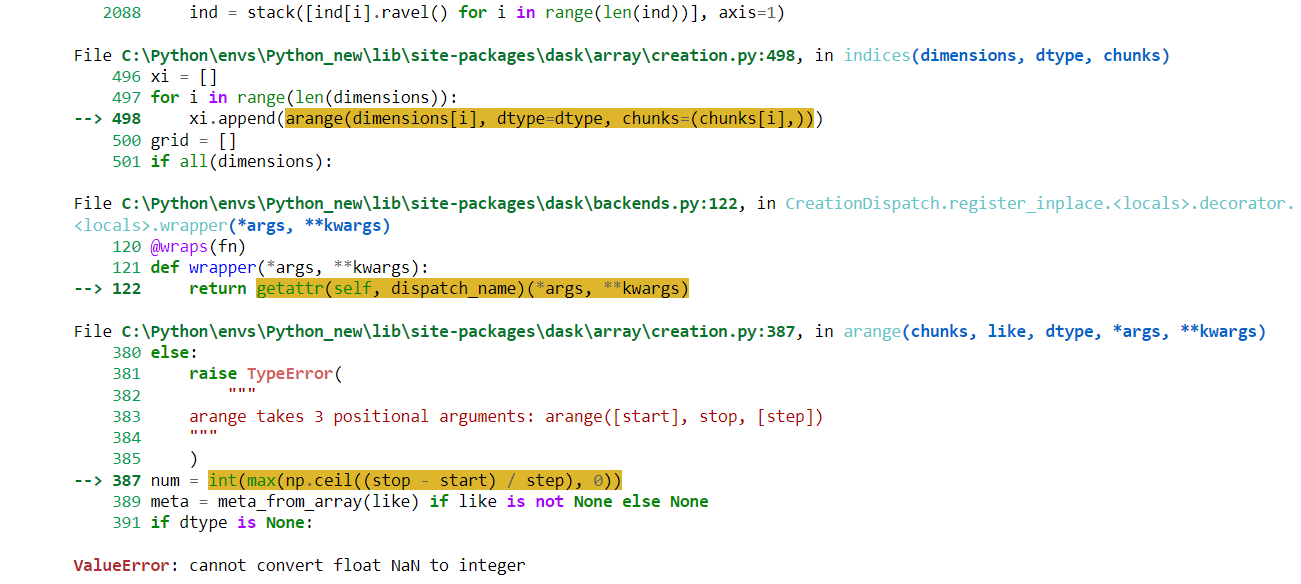

In [ ]:
#min_value = L1_diff.min()

indexes = L1_diff == min_value
min_index = da.where(indexes == True)[0][0]

In [19]:
emb[min_index, :10].compute()

array([-0.03955906,  0.00647067,  0.02269384, -0.08420704, -0.00360685,
       -0.01134263, -0.01475033,  0.05443913,  0.01077477, -0.02883131],
      dtype=float32)

5\. Рецепты разбиты на 4 группы. Загрузите маску для разбиения на группы из датасета `mask` из файла `recipe_embeddings.h5` в виде `dask.array`. Для каждой группы посчитайте и выведите на экран максимальное значение  нормы $\ell_1$ векторов рецептов, принадлежащих к этой группе. 

Подсказка: закодируйте маску принадлежности к группе при помощи метода кодирования one-hot encoding и воспользуйтесь механизмом распространения.

$$\ell_1: ||\textbf{x}||_1=\sum_{k=1}^{n}{|x_k|}, \textbf{x} \in \mathbb{R}^n$$

In [20]:
mask = da.from_array(hdf['mask'], chunks = 1200000 / 12)
a = mask.compute()
mask.compute()

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [21]:
emb

dask.array<array, shape=(1200000, 312), dtype=float32, chunksize=(100000, 312), chunktype=numpy.ndarray>

In [22]:
mask

dask.array<array, shape=(1200000,), dtype=int64, chunksize=(100000,), chunktype=numpy.ndarray>

In [27]:
df = from_pandas(pd.DataFrame(columns = ['mask', 'embendings'], index = range(1200000)), npartitions = 12)
df['mask'] = mask
df['embendings'] = da.sum(emb, axis = 1)
df.groupby(['mask']).max().compute()

,embendings
mask,
0,0.894194
1,0.888202
2,0.890275
3,0.855774


6\. Пусть $X=[\textbf{x}_1,...\textbf{x}_M]^\top$ - матрица эмбеддингов рецептов размера $M\times N$, $W=[\textbf{w}_1,...,\textbf{w}_N]^\top$ - матрица коэффициентов некоторой модели машинного обучения размера $N\times 4$, $y=[y_1,...,y_M]^\top$ - вектор размера $M$, содержащий номера групп рецептов (метки классов). Тогда задачу классификации можно решить следующим образом: $$\hat{y_i} = argmax_j{<X_{i\cdot}, W_{\cdot j}>}$$ где $A_{i\cdot}$ обозначает $i$ строку матрицы, $A_{\cdot j}$ обозначает $j$ столбец матрицы, $\hat{y_i}$ - прогноз класса для рецепта $i$, $<\cdot, \cdot>$ - скалярное произведение векторов.

Инициализируйте матрицу $W$ случайным образом и получите прогнозы для всех рецептов при помощи этой матрицы и матрицы эмбеддингов. Подсчитайте и выведите на экран значение accuracy на основе полученных прогнозов $\hat{y}$ и правильных ответов $y$.

In [176]:
X = emb
W = da.random.random((312, 4))
y = mask

In [179]:
y_pred = da.argmax(X @ W, axis = 1)

In [180]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)

0.4117075

7\. Сингулярным разложением (SVD) матрицы $A$ размера $M\times N$ называется разложение вида $A = USV^\top$, где $U$ - матрица размера $M\times N$  ортонормированных векторов произведения $AA^\top$, $V^T$ - транспонированная матрица размера $N\times N$ ортонормированных векторов произведения $A^\top A$, $S$ - диагональная матрица сингулярных значений размера $N\times N$.

SVD может быть использовано для понижения размерности векторов. Для этого от матрицы $U$ оставляют первые $k$ столбцов $U_{\cdot,:k}$, от матрицы $S$ оставляют левый верхний квадрат размера $k\times k$ $S_{:k,:k}$ и вычисляется произведение $\hat{A} = U_{\cdot,:k}S_{:k,:k}$

Выберите эмбеддинги тех рецептов, которые относятся к группе с номеров 3, и уменьшите их размерность до 64 при помощи реализации алгоритма SVD из пакета `dask.array.linalg`. Выведите количество строк и столбцов полученного массива.

Примечание: после отбора рецепта, принадлежащих третьей группе, вызовите у полученного массива метод `compute_chunk_sizes`, чтобы `dask` обновил метаинформацию в этом массиве. 

8\. Используя эмбеддинги уменьшенной размерности, полученные в задании 6, посчитайте косинусное сходство между каждой парой рецептов третьей группы. Выведите матрицу косинусного сходства на экран.

9\. Посчитайте и выведите на экран количество рецептов, для которых рецепт с индексом `242` входит число топ-5 ближайших рецептов в смысле косинусной близости. При поиске топ-5 рецептов для конкретного рецепта считайте, что он сам в это число не входит.

10\. Графом называется совокупность двух множеств $G=(V,E)$: множества $V=\{v_1, ..., v_M\}$ узлов и множества ребер $E=\{(v_i, v_j)|v_i\in V, v_j\in V\}$, соединяющих эти узлы. Матрицей смежности невзвешенного графа называется квадратная матрица $A=[a_{ij}]$, в которой ${a_{ij}}$ обозначает количество ребер, соединяющих вершины $i$ и $j$.

Постройте матрицу смежности для графа рецептов на основе матрицы косинусного сходства между каждой парой рецептов. Будем считать, что между двумя рецептами в этом графе существует ребро, если косинусное сходство между двумя этими рецептами не менее 0.85. Петли (ребра из вершины в саму в себя) в графе должны отсутствовать. Посчитайте и выведите на экран количество ребер в данном графе. Проверьте, является ли полученная матрица смежности симметричной.

Примечание: считайте, что два различных рецепта не могут иметь косинусное сходство, равное 1.

11\. Работая с исходным файлом в формате `h5`, реализуйте алгоритм подсчета среднего вектора датасета в блочной форме.

Блочный алгоритм вычислений состоит из двух частей:
1. Загрузка фрагмента за фрагментом данных и проведение вычислений над этим фрагментом
2. Агрегация результатов вычислений на различных фрагментах для получения результата на уровне всего набора данных

Важно: при работе с `h5` в память загружаются не все элементы, а только те, которые запрашиваются в данный момент. При работе с `h5` вы можете работать с массивами `numpy.array`. Для итерации по сегментам файла допускается использование циклов.

Сравните время и результаты решения работы вашего алгоритма с реализацией поиска среднего вектора из `dask`. 